In [1]:
import numpy as np
import copy

# CVRP Instance

In [2]:
class CVRPInstance:
    def __init__(self):
        self.name = ""
        self.num_trucks = 0
        self.dimension = 0
        self.capacity = 0
        self.depot_x = 0
        self.depot_y = 0
        self.customer_demands = []
        self.customer_x = []
        self.customer_y = []
        self.distances = []

def read_cvrp_instance(file_path):
    instance = CVRPInstance()

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Parsing basic information
        instance.name = lines[0].split(":")[1].strip()

        # Extracting the number of trucks from the comment
        comment_parts = lines[1].split(",")
        for part in comment_parts:
            print("part", part)
            if "No of trucks" in part:
                instance.num_trucks = int(part.split()[-1])
                break

        instance.dimension = int(lines[3].split(":")[1])
        instance.capacity = int(lines[5].split(":")[1])

        # Parsing depot coordinates
        instance.depot_x, instance.depot_y = map(float, lines[7].split()[1:])

        # Parsing customer information
        for line in lines[7:7+ instance.dimension]:
            if line.startswith("DEMAND_SECTION"):
                break
            _, x, y = map(float, line.split())
            instance.customer_x.append(x)
            instance.customer_y.append(y)

        for line in lines[7 + instance.dimension+1:7 + instance.dimension+1+ instance.dimension]:
            if line.startswith("DEPOT_SECTION"):
                break
            _, demand = map(int, line.split())
            instance.customer_demands.append(demand)
            
        # Calculate distances based on Euclidean distance
        instance.distances = np.zeros((instance.dimension, instance.dimension))
        for i in range(instance.dimension):
            for j in range(instance.dimension):
                instance.distances[i][j] = np.sqrt((instance.customer_x[i] - instance.customer_x[j])**2 +
                                                  (instance.customer_y[i] - instance.customer_y[j])**2)

    return instance

# Plot functions

In [3]:
import matplotlib.pyplot as plt
def draw_path(customer_x, customer_y, path):
    # Extract coordinates for the path
    path_coordinates_x = [customer_x[i] for i in path]
    path_coordinates_y = [customer_y[i] for i in path]

    # Find the indices where the path returns to customer 0
    return_indices = [i for i, value in enumerate(path) if value == 0]

    # Plot the path, changing color when returning to customer 0
    plt.figure(figsize=(8, 8))
    for i in range(len(return_indices) - 1):
        start_index = return_indices[i]
        end_index = return_indices[i + 1]
        plt.plot(path_coordinates_x[start_index:end_index+1], path_coordinates_y[start_index:end_index+1], marker='o', linestyle='-')

    # Mark customer locations with indices
    for i, (x, y) in enumerate(zip(customer_x, customer_y)):
        plt.text(x, y, str(i), ha='center', va='center', color='red', fontweight='bold')

    plt.title('Best Solution Path with Customer Indices')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

def plot_function(aco_instance):
    draw_path(cvrp_instance.customer_x, cvrp_instance.customer_y, aco_instance.concatenate_best())
    print(aco_instance.best_ant_global_length) 


# ACO Class

In [4]:

class AntColonyOptimization:

    def __default_h_calc(self, dist_mtx: np.ndarray) -> np.ndarray:
        heuristic_mtx = np.ones_like(dist_mtx, dtype=np.float64)
        nonzero_indices = dist_mtx > 0.0

        heuristic_mtx[nonzero_indices] /= dist_mtx[nonzero_indices]

        for i in range(dist_mtx.shape[0]):
            heuristic_mtx[i][i] = 0

        return heuristic_mtx

    def __init__(self,
                 dist_mtx: np.ndarray,
                 demand,
                 max_cap,
                 n_nodes,
                 n_ants: int,
                 plot_function,
                 max_it: int = 100,
                 evaporation_rate: float = 0.1,
                 alpha: float = 1.0,
                 betha: float = 1.0,
                 heuristic_calc_func=None,
                 verbose=False
                ) -> None:
        self.dist_mtx = dist_mtx
        self.n_ants = n_ants
        self.max_it = max_it
        self.evapr = evaporation_rate
        self.alpha = alpha
        self.betha = betha
        self.verbose = verbose
        self.plot_function = plot_function
        self.demand = np.array(demand)
        self.max_cap = max_cap
        self.n_nodes = n_nodes
        self.pending_customers_all = set(range(self.n_nodes))

        self.heuristic_calc_func = self.__default_h_calc
        if heuristic_calc_func is not None:
            self.heuristic_calc_func = heuristic_calc_func

        self.pher_mxt = None
        self.hstc_mtx = None
        self.best_ant_global = None
        self.best_ant_global_length = None

    def __init_var(self):
        self.hstc_mtx = self.__default_h_calc(self.dist_mtx)
        self.pher_mxt = np.ones_like(self.dist_mtx) 
        #self.best_ant = np.zeros((self.dist_mtx.shape[0]))
        
    def test_print(self):
        print(self.hstc_mtx)
        print(self.pher_mxt)

    def solve(self, n_prints:int=10):
        print_interval = int(self.max_it/n_prints)

        self.__init_var()
        ant_path_len = np.zeros((self.n_ants))
        count_best = 0
        prev_best = None
        for k in range(self.max_it):
            ant_paths = []
            for i in range(self.n_ants):
                ant_path = []
                route = [0]
                ant_capacity = self.max_cap
                pending_customers = set(range(self.n_nodes))
                visited_customers = set([0])
                pending_customers.remove(0)
                j = 1 #current path position
                while len(pending_customers)>0:
                    probs, flag = self.__move_prob(visited_customers, int(route[j - 1]),ant_capacity )
                    if  flag == 0:
                        route.append(0)
                        j=0
                        ant_path.append(route.copy())
                        route = [0]
                        ant_capacity = self.max_cap
                    else:
                        route.append( np.random.choice(np.arange(self.dist_mtx.shape[0]), p=probs) )
                        visited_customers.add(route[j])
                        pending_customers.remove(route[j])
                        ant_capacity -= self.demand[route[j]]
                    j = j+1
                
                if route[j-1] != 0: #returns to origin
                    route.append(0)   
                    ant_path.append(route.copy())
                    
      
                #mutate
                ant_path = self.mutate2(ant_path)

                #2-opt
                for z in range(len(ant_path)):
                    ant_path[z] = self.two_opt_heuristic(ant_path[z])

                ant_paths.append(copy.deepcopy(ant_path))
                ant_path_len[i] = 0
                for z in range(len(ant_path)):
                    ant_path_len[i]  += self.__path_len(ant_path[z])
       
                if (self.best_ant_global_length == None) or ant_path_len[i] < self.best_ant_global_length:
                    self.best_ant_global = ant_path.copy()
                    self.best_ant_global_length = ant_path_len[i]
            
            if(prev_best != None ) and prev_best == self.best_ant_global_length :
                count_best+=1
            else:
                count_best = 0
            
            if count_best == 0:
                self.pher_mxt *= (1- self.evapr)
            elif count_best == 3:
                self.pher_mxt *= (0.6)
                count_best = 0
            elif count_best == 6:
                #rnd_path = np.random.randint(len(ant_paths))
                #ant_paths[rnd_path] = self.crazyMutate(ant_paths[rnd_path] )
                self.pher_mxt *= (0.3)
                count_best = 0
            
            
            prev_best = self.best_ant_global_length 

            best_ant_gen_idx = np.argmin(ant_path_len)
            
            #actualizacion tomando solo la mejor de la generación
            for i in range(len(ant_paths[best_ant_gen_idx])):
                self.__update_pheromones(ant_paths[best_ant_gen_idx][i], ant_path_len[best_ant_gen_idx])
            
            if k%print_interval == 0 and self.verbose == True:
                print("it: ",k)
                self.plot_function(self)

        return self.concatenate_best(), self.best_ant_global_length  
    
    def crazyMutate(self, ant_path):
        
        rnd_route_idx = np.random.randint(len(ant_path))
        rnd_route_demand = self.calculate_demand(ant_path[rnd_route_idx])
 
        rnd_customer = np.random.randint((1, (len(ant_path[rnd_route_idx]))-1))
        
        infalible_idx = np.where(self.demand + rnd_route_demand > self.max_cap)

        probs = np.ones((self.hstc_mtx.shape[0]))

        probs[ant_path[rnd_route_idx]] = 0
        probs[infalible_idx] = 0
        
        if np.sum(probs)==0:
            return ant_path
        
        probs /= np.sum(probs)
        
        customer_selected = np.random.choice(np.arange(self.dist_mtx.shape[0]), p=probs)
        for i in range(len(ant_path)):
            if customer_selected in ant_path[i]:
                index = np.where(ant_path[i] == customer_selected)[0]
                ant_path[i] = np.delete(ant_path[i], index)
                ant_path[rnd_route_idx][len(ant_path[rnd_route_idx])-1] = customer_selected
                ant_path[rnd_route_idx] = np.append(ant_path[rnd_route_idx],0)
                break
        
        return ant_path
    
    
    def mutate2(self, ant_path):
        prob_demand = np.ones((len(ant_path)))
        routes_demand = []
        for i in ant_path:
            routes_demand.append(self.calculate_demand(i))
        routes_demand = np.array(routes_demand)   
        prob_demand /= routes_demand
        prob_demand = prob_demand / np.sum(prob_demand)
        
        rnd_route_idx = np.random.choice(np.arange(len(ant_path)), p=prob_demand)
        rnd_route_demand = self.calculate_demand(ant_path[rnd_route_idx])
        rnd_customer = np.random.randint(1, (len(ant_path[rnd_route_idx])-1))
        
        heur = np.copy(self.hstc_mtx[rnd_customer])
        heur[ant_path[rnd_route_idx]] = 0
        
        infalible_idx = np.where(self.demand + rnd_route_demand > self.max_cap)

        heur[infalible_idx] = 0
        if np.sum(heur)==0:
            return ant_path
        probs = heur/np.sum(heur)
        
        customer_selected = np.random.choice(np.arange(self.dist_mtx.shape[0]), p=probs)
        for i in range(len(ant_path)):
            if customer_selected in ant_path[i]:
                index = np.where(ant_path[i] == customer_selected)[0]
                ant_path[i] = np.delete(ant_path[i], index)
                ant_path[rnd_route_idx][len(ant_path[rnd_route_idx])-1] = customer_selected
                ant_path[rnd_route_idx] = np.append(ant_path[rnd_route_idx],0)
                break
        
        return ant_path
    
    
    
    def redistribute_demand(self, ant_path):
        route_less_demand_idx = None
        less_demand = None
        for i in range(len(ant_path)):
            tmp_demand = self.calculate_demand(ant_path[i])
            if less_demand == None or tmp_demand < less_demand:
                less_demand = tmp_demand
                route_less_demand_idx = i
        rnd_customer = np.random.randint(1, (len(ant_path[route_less_demand_idx])-1))
        heur = np.copy(self.hstc_mtx[rnd_customer])
        heur[ant_path[route_less_demand_idx]] = 0
        infalible_idx = np.where(self.demand + less_demand > self.max_cap)
        heur[infalible_idx] = 0
        probs = heur/np.sum(heur)
        customer_selected = np.random.choice(np.arange(self.dist_mtx.shape[0]), p=probs)
        for i in range(len(ant_path)):
            if customer_selected in ant_path[i]:
                index = np.where(ant_path[i] == customer_selected)[0]
                ant_path[i] = np.delete(ant_path[i], index)
                ant_path[route_less_demand_idx][len(ant_path[route_less_demand_idx])-1] = customer_selected
                ant_path[route_less_demand_idx] = np.append(ant_path[route_less_demand_idx],0)
        
        return ant_path
    
    def print_final_capacities(self):
        for p in range(len(self.best_ant_global)):
            print("route ",p," : ", self.calculate_demand(self.best_ant_global[p]))
    
    def mutate(self,ant_path):
        orig_ant_path = copy.deepcopy(ant_path)
        rnd_route1 = np.random.randint(len(orig_ant_path))
        rnd_customer1_idx = np.random.randint(1, (len(orig_ant_path[rnd_route1])-1) ) #except origin 0
        customer1 =  orig_ant_path[rnd_route1][rnd_customer1_idx]
        rnd_route1_demand = self.calculate_demand(orig_ant_path[rnd_route1])
        orig_ant_len = 0
        for z in range(len(orig_ant_path)):
            orig_ant_len  += self.__path_len(orig_ant_path[z])
        
        best_ant = copy.deepcopy(ant_path)
        best_ant_length = orig_ant_len
        for k in range(len(orig_ant_path)):
            if k == rnd_route1:
                continue
            curr_path = orig_ant_path[k]
            rnd_route2_demand = self.calculate_demand(curr_path)
            for l in range(len(curr_path)):
                customer2 = curr_path[l]
                if(customer2==0):
                    continue
                temp_ant_path = copy.deepcopy(orig_ant_path)
                if ((rnd_route1_demand - self.demand[customer1] + self.demand[customer2]) <= self.max_cap) and ((rnd_route2_demand + self.demand[customer1] - self.demand[customer2]) <= self.max_cap):
                    temp_ant_path[rnd_route1][rnd_customer1_idx] = customer2
                    temp_ant_path[k][l] = customer1
                    temp_len = 0
                    for z in range(len(temp_ant_path)):
                        temp_len  += self.__path_len(temp_ant_path[z])
                    if best_ant_length == None or temp_len<best_ant_length:
                        best_ant = copy.deepcopy(temp_ant_path)
                        best_ant_length = temp_len
        return best_ant

        
    def calculate_demand(self, path):
        return np.sum(self.demand[path])
        
    def two_opt_heuristic(self, path):
        path_len = self.__path_len(path)
        #print("orig: ", path_len )
        for i in range(1, len(path)-2):
            for j in range(i+1, len(path)-1):
                new_path = np.copy(path)
                aux = new_path[i]
                new_path[i] = new_path[j]
                new_path[j] = aux
                #print("new path ", new_path)
                new_path_len = self.__path_len(new_path)
                if new_path_len < path_len:
                    path = np.copy(new_path)
                    path_len = new_path_len
        #print("final: ", path_len )
        return path

    def test(self):
        arr = np.array([20  ,5 ,25 ,10, 15 , 9 ,22 , 8 ,18, 29 ])
        best_route = self.two_opt_heuristic(arr)
        print(best_route)
    
    def __move_prob(self, visited, current, ant_capacity):
        visited = np.array(list(visited))
        pheromones = np.copy(self.pher_mxt[current])
        #print("pher size ", len(pheromones))
        heuristics = self.hstc_mtx[current]
        # Cast the values in 'visited' to integers and set corresponding pheromones to 0
        visited_indices = np.array(visited, dtype=np.int64)
        pheromones[visited_indices] = 0
    
        #infalible indices
        infalible_indices = np.where( (ant_capacity - self.demand) < 0)[0]
        pheromones[infalible_indices] = 0
        probabilities = pheromones ** self.alpha * heuristics ** self.betha
        den = np.sum(probabilities)
        if den == 0.0:
            return (0 , 0)
        probabilities = probabilities / den
        return (probabilities, 1)
    
    def concatenate_best(self):
        path = self.best_ant_global[0]
        for i in range(1,len(self.best_ant_global)):
            path = np.concatenate((path, self.best_ant_global[i][1:] ))
            
        return path

    def __path_len(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += self.dist_mtx[int(path[i])][int(path[i + 1])]
        return length

    def __update_pheromones(self, path, length):
        for i in range(len(path) - 1):
            self.pher_mxt[int(path[i])][int(path[i + 1])] += 1.0 / length
            self.pher_mxt[int(path[i + 1])][int(path[i])] += 1.0 / length
            

# Test

part COMMENT : (Augerat et al
part  No of trucks: 5
it:  0


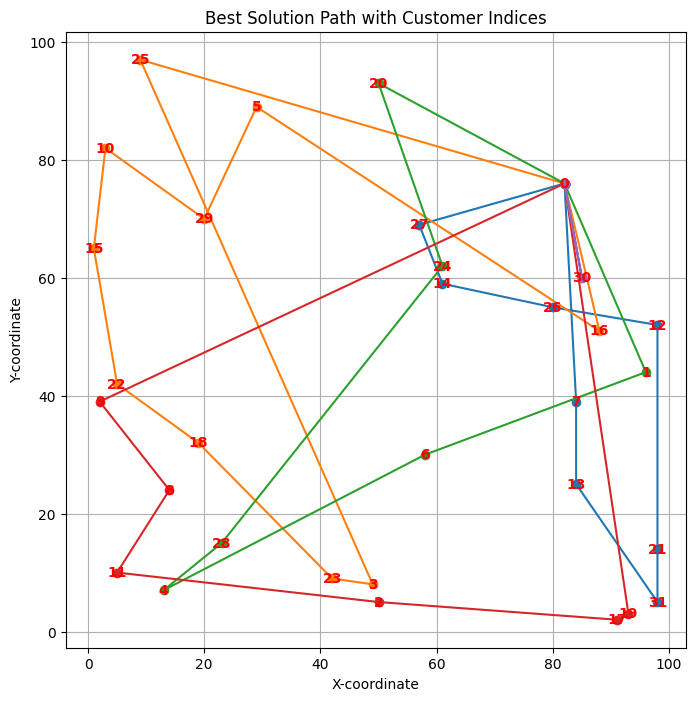

1192.7226083917726
it:  100


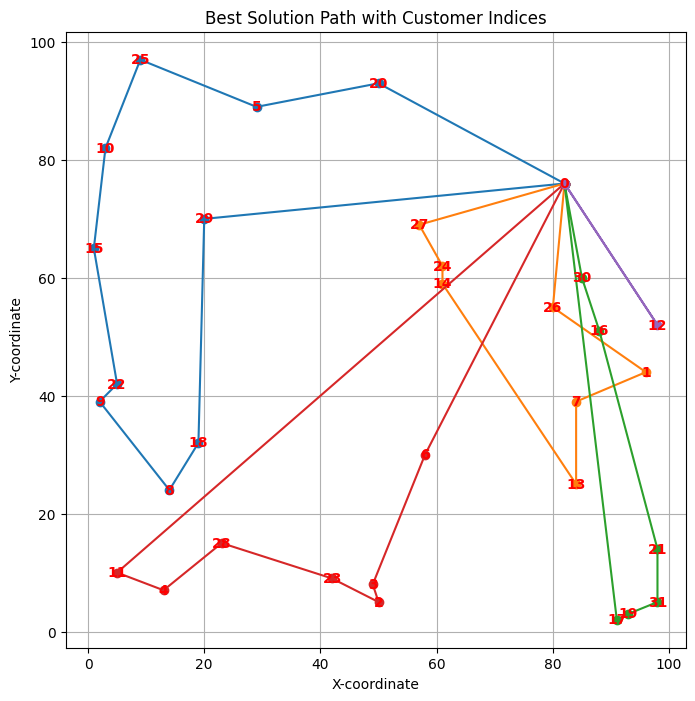

857.9437542077518
it:  200


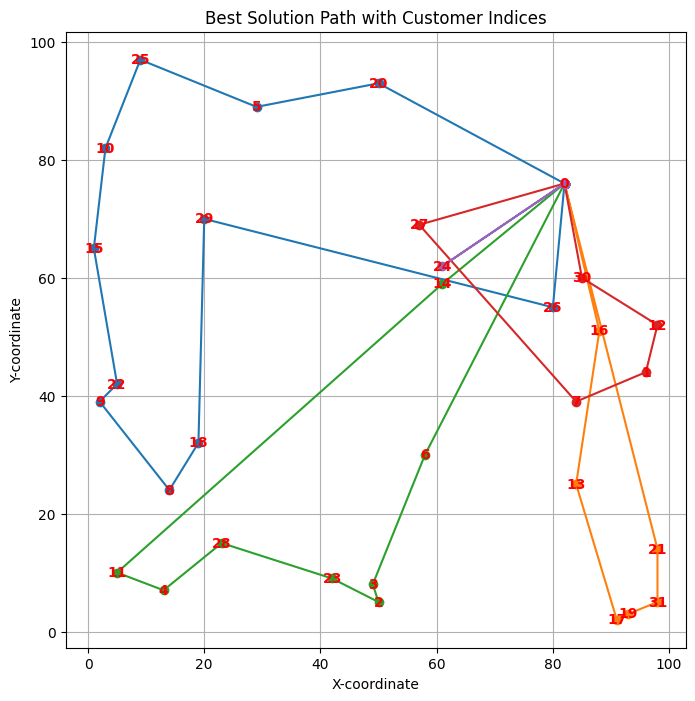

846.3770867396065
it:  300


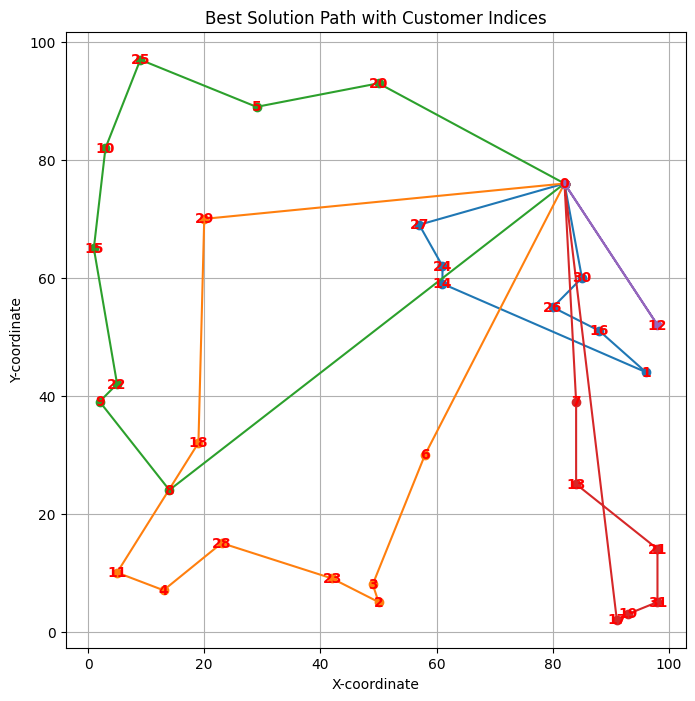

835.9835601821934
it:  400


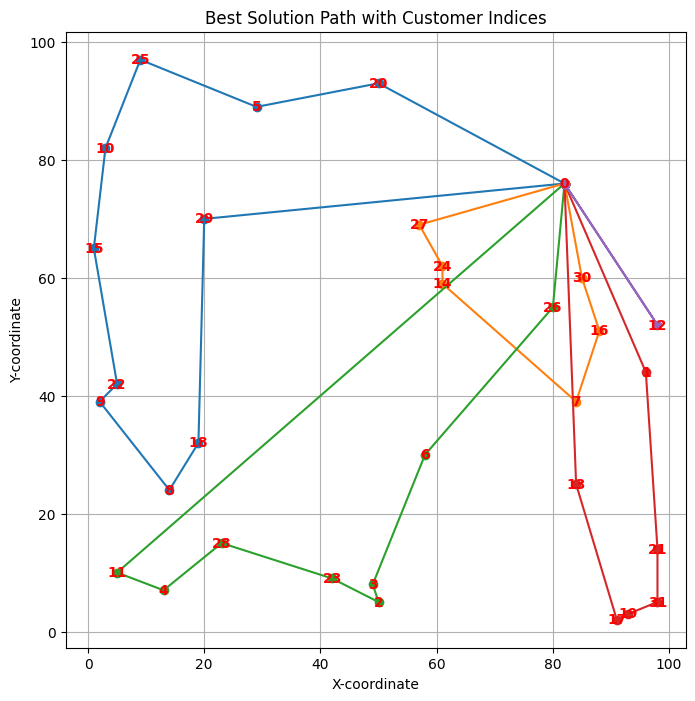

822.2273896298973
it:  500


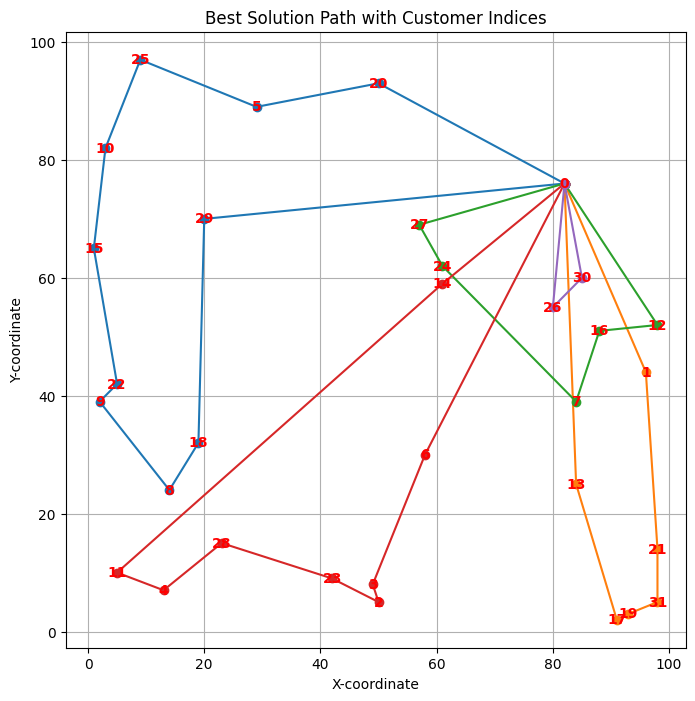

818.6618798097229
it:  600


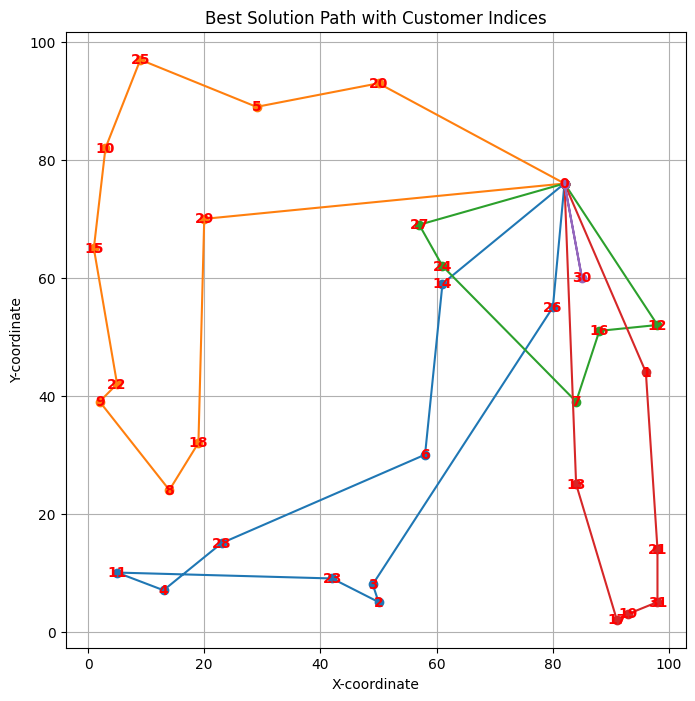

818.4294264185688
it:  700


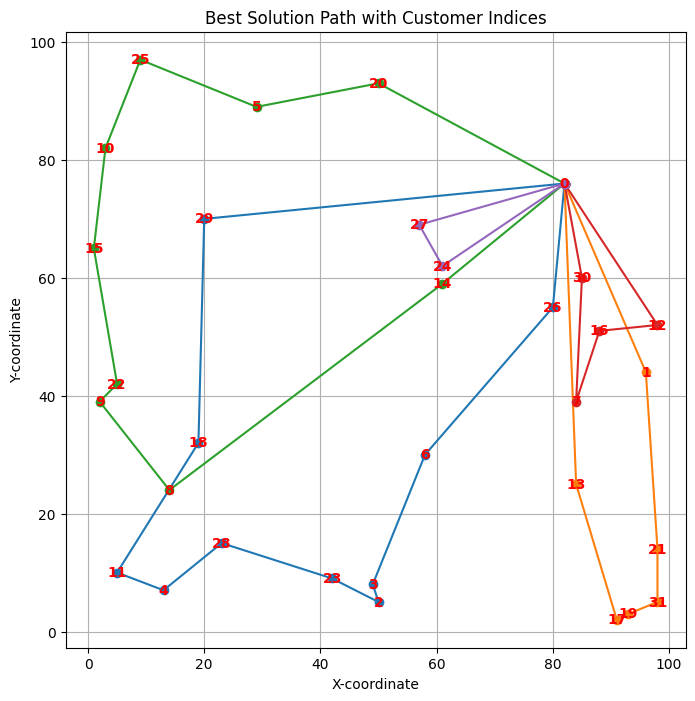

807.5758686551006
it:  800


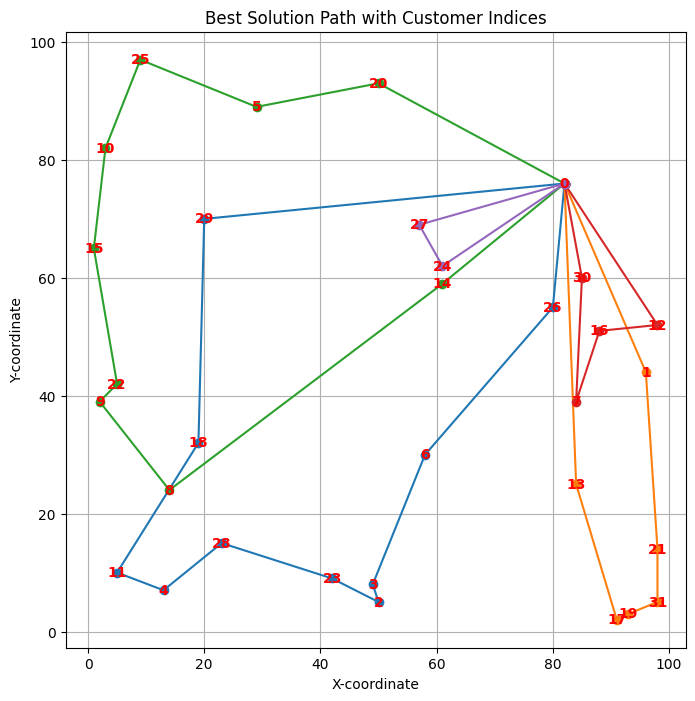

807.5758686551006
it:  900


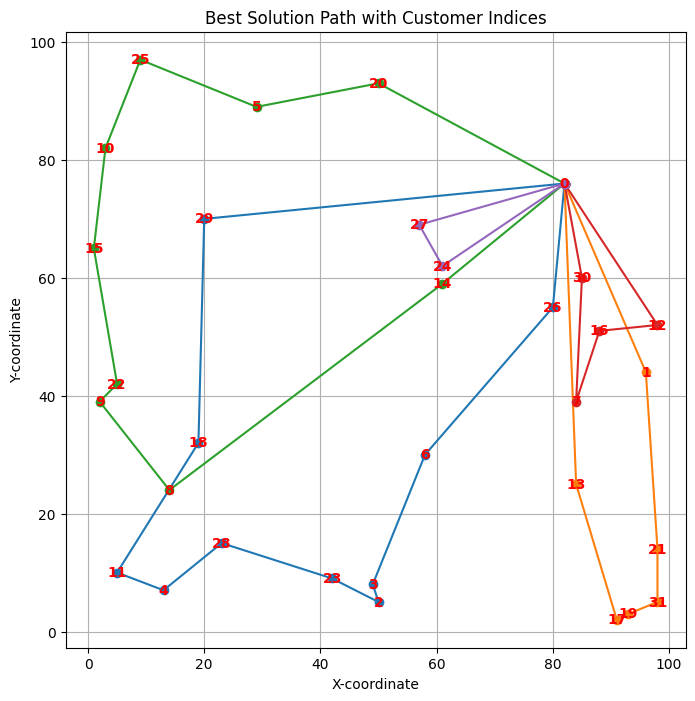

807.5758686551006
Best Solution: [ 0 12  1  7 24 27  0  6  3  2 23 28  4 11 18 29  0 20  5 25 10 15 22  9
  8 14  0 16 21 31 19 17 13 26  0 30  0]
Best Solution Length: 805.5176628670342


In [5]:

# Load your CVRP instance
file_path = "Vrp-Set-A\A\A-n32-k5.vrp"
cvrp_instance = read_cvrp_instance(file_path)

# Create an AntColonyOptimization instance
aco_solver = AntColonyOptimization(
    dist_mtx=cvrp_instance.distances,
    demand=cvrp_instance.customer_demands,
    max_cap=cvrp_instance.capacity,
    n_nodes = cvrp_instance.dimension,
    n_ants=50,
    plot_function=plot_function,
    max_it=1000,
    evaporation_rate=0.1, #0.1
    alpha=3.0, #1.5
    betha=1.0, #1.0
    verbose=True
)

# Solve the CVRP using Ant Colony Optimization
best_solution, best_length = aco_solver.solve()
#print(aco_solver.test())
# Display the best solution and its length
print("Best Solution:", best_solution)
print("Best Solution Length:", best_length)

# Validations

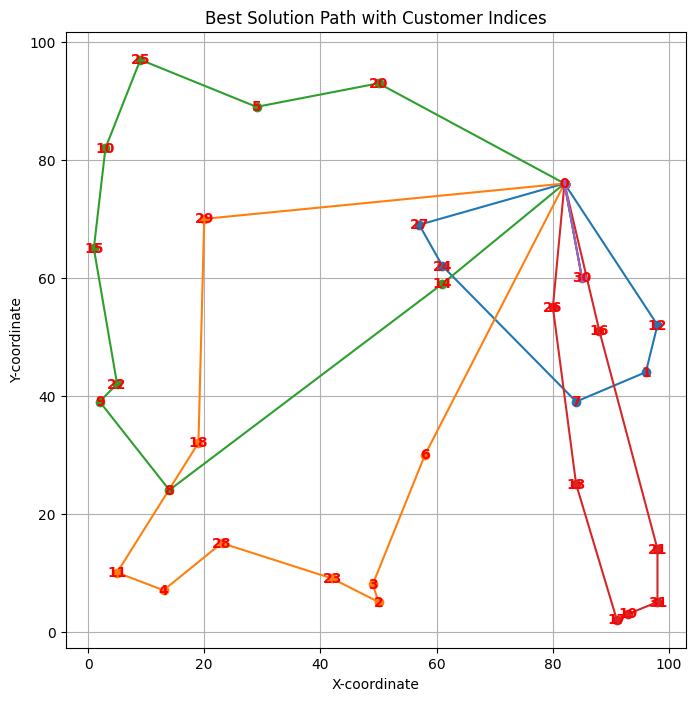

In [6]:
draw_path(cvrp_instance.customer_x, cvrp_instance.customer_y,best_solution)

In [7]:
import math
def calculate_total_length(customer_x, customer_y, path):
    total_length = 0.0

    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i + 1]

        x1, y1 = customer_x[current_node], customer_y[current_node]
        x2, y2 = customer_x[next_node], customer_y[next_node]

        # Calculate Euclidean distance
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_length += distance

    return total_length

In [8]:
total_length = calculate_total_length(cvrp_instance.customer_x, cvrp_instance.customer_y, best_solution)
print(total_length)

805.517662867034
